In [1]:
import numpy as np
import pandas as pd

from numpy import ndarray

## Gradient Descent

A function to measure, how close $h(x^{(i)})$ is to the corresponging $y^{(i)}$ for each weight $\theta$ is the **mean square error cost function** 

$$ \nabla_{\theta}J(\theta) = \frac{1}{2m}\sum_{i=0}^m(h_0(x^{(i)})-y^{(i)})$$

As a next step it is the task to choose a $\theta$, so as to minimize $J(\theta)$. There are several approaches to minimize $J(\theta)$. The goal is to reach a global minimum of the cost function. 

To reach this goal $\theta$ has to be chosen to minimize $J(\theta)$. One algorithm starts with an "initial guess" and repitedly changes $\theta$ to decrease $J(\theta)$ until it converges to a value $\theta$ with a minimal $J(\theta)$. This algorithm is called **gradient descent**.

$$ \theta_{j} := \theta_{j} - \eta\nabla_{\theta}J(\theta) $$

with: <br>
>    $\eta$ ... learning rate<br>

With solving the partial derivative the update rule can be write like: 

$$ \theta_{j} := \theta_{j}- \eta \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} $$

$ \theta_{j}$ will be simultaneously updated for all j. With each step of gradient descent, the parameters $\theta_j$ will come closer to the optimal values of $J(\theta)$.

**Stochastic gradient descent (SGD)** updates the weights after every training sample.


For regression problems there are more cost functions than **MSE**. The **mean absolute error (MAE)** is the mean of the absolute differences between the output and the target. One advantage of MAE is, that it can handle outliers in the data better. MSE increases exponentially, when the error is > 1, which may skew the results by outsized weights.
On the other hand, the slope near 0 is steeper, compared to MSE, which makes it harder to figure out, how close the cost function is towards the minimum.

**Huber loss** tries to fix the problems of MSE and MAE by combining their properties. In short, if the difference between output and target is below a threshold $\delta$ the Huber loss behaves like MSE, above it behaves like MAE. So it is less sensitive to outliers and at the same time, the minimum of the function is differentiable.

TODO: description of classification cost function: cross-entropy and kl divergence

## Momentum

**Momentum** is an improvement for the SGD, where the current weight update will be weighted by the previous weight updates. The intuition comes from the analogy of rolling a ball down a hill like gradient descent follows the "loss function surface" towards the minimum. The ball will gain velocity and the more the ball travels the faster it will become. The ball will gain momentum. The same idea is behind the momentum for gradient descent.

First we calculate the weight update $v_t$ by also including the previous update $v_{t-1}$

$$ v_t = \alpha v_{t-1} - \eta\nabla_{\theta}J(\theta) $$

with: <br>
>    $\alpha$ ... momentum parameter <br>


and then, we perform the actual weight update

$$ \theta_{j} := \theta_{j} + v_t$$


**Nesterov momentum** is another improvement over the standard momentum method. It differs, where the gradient is evaluated.  The Nesterov momentum is evaluated after the current "velocity" is applied. 
So stepwise the gradient descent will look like:

$$ \tilde{\theta_{j}} := \theta_{j} + \alpha v_{t-1} $$


$$ v_t = \alpha v_{t-1} - \eta\nabla_{\theta}J(\tilde{\theta_{j}}) $$

with the weight update: 

$$ \theta_{j} := \theta_{j} + v_t $$


**Adam** adaptive learning rate calculates indiviual and adaptive learning rates for every weight based on previous momentum. Also Adam is an adaptive learning rate algorithm, so it  requires less tuning  of the learning rate hyperparameter $\eta$. 

First we calculate the 1st and 2nd momentum of the gradient:

$$m_t := \beta_1 m_{t-1} + (1-\beta_1)\nabla_{\theta}J(\theta) $$
$$v_t := \beta_2 v_{t-1} + (1-\beta_2) \nabla_{\theta}^2 J(\theta) $$

with: <br>
>    $\beta_1$ ... hyperparameter (default 0.9) <br>
>    $\beta_2$ ... hyperparameter (default 0.999) <br>

$m_t$ and $v_t$ are behaving as an moving-verage of the gradients. In the initial phase of the training they start with 0 and add a bias towards the weight update. To compensate this bias, following corrections had to be performed:

$$ \hat{m_t} = \frac{m_t}{1-\beta_1^t} $$
$$ \hat{v_t} = \frac{v_t}{1-\beta_2^t} $$


and the weight update looks like: 

$$ \theta_{j} := \theta_{j} - \eta\frac{\hat{m_t}}{\sqrt{\hat{v_t} + \epsilon}} $$

with: <br>
>    $\epsilon$ ... small value to prevent division by 0<br>


## Learning rate decay

Setting the right learning rate can be tricky, since you want to avoid over- and underfitting. Also if the learning rate is set too low, it can take ages until a model converges to an optimum.

Since adaptive optimizers like Adam, AdaGrad or RMSProp automatically reduce the learning rate during training, it is not necessary to add a learning rate decay. 

In the beginning of a traing progress, the idea is to have bigger update steps towards the weights, since we are far away from the global minimum. The longer the training goes on, the more the model converges to the global minimum. Normally, this decrease of the weight updates, is part of gradient descent, but with an adapation of the learning rate, there is a more fine-grained control over this process.

There are multiple ways to calculate the learning rate decay, the simplest is a linear decay of the learning rate and another simple one is the exponential decay.

The formula for the linear decay is:

$$ \eta_t = \eta_{start} - (\eta_{start} - \eta_{end}) * \frac{t}{N}$$

and for the exponential decay is:

$$ \eta_t = \eta * \delta^t $$

with:

$$ \delta = \frac{\eta_{end}^{\frac{1}{N-1}}}{\eta_{start}} $$ 

with: <br>
>    $N$ ... as total number of epochs<br>


## Application

In [2]:
from utils import NeuralNetwork, Dense, Sigmoid, Linear, MeanSquaredError, Trainer

In [3]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
def to_2d_np(a: ndarray,
          type: str="col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"

    if type == "col":
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)
    
    

def eval_model(model: NeuralNetwork,
                          X_test: ndarray,
                          y_test: ndarray):

    prediction = model.forward(X_test)
    prediction = prediction.reshape(-1, 1)
    print("Mean absolute error: {:.2f}".format(mean_absolute_error(prediction, y_test)))
    print("\nRoot mean squared error {:.2f}".format(mean_squared_error(prediction, y_test, squared=False)))

In [5]:
boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

In [6]:
s = StandardScaler()
data = s.fit_transform(data)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

# make target 2d array
y_train, y_val, y_test = to_2d_np(y_train), to_2d_np(y_val), to_2d_np(y_test)

In [8]:
neural_network = NeuralNetwork(layers=[Dense(neurons=13,
                                            activation=Sigmoid()),
                                      Dense(neurons=1,
                                            activation=Linear())],
                                loss=MeanSquaredError(),
                                seed=1
                                )

neural_network_2 = NeuralNetwork(layers=[Dense(neurons=13,
                                            activation=Sigmoid()),
                                         Dense(neurons=13,
                                            activation=Sigmoid()),
                                      Dense(neurons=1,
                                            activation=Linear())],
                                loss=MeanSquaredError(),
                                seed=1
                                )


## Optimizers

First we need to implement the learning rate decay in the optimizer

In [9]:
class Optimizer:
    """
    Base class for an optimizer.
    """

    def __init__(self, lr: float = 0.01,
                final_lr: float = 0.0,
                decay_type: str = None):

        self.lr = lr
        self.final_lr = final_lr
        self.decay_type = decay_type
        self.first = True
        
    def _setup_decay(self) -> None:
        
        if not self.decay_type:
            return None
        
        elif self.decay_type == "linear":
            self.decay_per_epoch = (self.lr - self.final_lr) / (self.max_epochs - 1)

        elif self.decay_type == "exponential":
            self.decay_per_epoch = np.power(self.final_lr / self.lr, 1.0 / (self.max_epochs - 1))
            
    def _decay_lr(self) -> None:
        
        if not self.decay_type:
            return None
        
        elif self.decay_type == "linear":
            self.lr -= self.decay_per_epoch
        
        elif self.decay_type == "exponential":
            self.lr *= self.decay_per_epoch
        
            
    def step(self, epoch: int=0) -> None:
        
        for (param, param_grad) in zip(self.net.params(), self.net.param_grads()):
            
            self._update_rule(param=param, grad=param_grad)
    
    def _update_rule(self, **kwargs) -> None:
        raise NotImplementedError()

In [10]:
class SGD(Optimizer):
    """
    Stochasitc gradient descent optimizer.
    """

    def __init__(self, lr: float = 0.01,
                 final_lr: float = 0,
                 decay_type: str = None) -> None:

        super().__init__(lr, final_lr, decay_type)

    def _update_rule(self, **kwargs) -> None:
        """
        Update each parameter ased on the learning rate.
        """
        update = self.lr*kwargs['grad']
        kwargs['param'] -= update

In [11]:
class SGDMomentum(Optimizer):
    """
    Stochasitc gradient descent optimizer with momentum.
    """

    def __init__(self, lr: float = 0.01,
                 final_lr: float = 0,
                 decay_type: str = None,
                momentum = 0.9) -> None:

        super().__init__(lr, final_lr, decay_type)
        self.momentum = momentum

    def step(self):
        """
        Update each parameter ased on the learning rate.
        """
        if self.first:
            self.velocities = [np.zeros_like(param)
                               for param in self.net.params()]
            self.first = False
            
        for (param, param_grad, velocity) in zip(self.net.params(), self.net.param_grads(), self.velocities):
            
            self._update_rule(param=param, grad=param_grad, velocity=velocity)
 
    def _update_rule(self, **kwargs) -> None:
        
            # Update velocity
            kwargs['velocity'] *= self.momentum
            kwargs['velocity'] += self.lr * kwargs['grad']

            # Use this to update parameters
            kwargs['param'] -= kwargs['velocity']

In [12]:
class SGDNesterov(Optimizer):
    """
    Stochasitc gradient descent optimizer with nesterov momentum.
    """

    def __init__(self, lr: float = 0.01,
                 final_lr: float = 0,
                 decay_type: str = None,
                momentum = 0.9) -> None:

        super().__init__(lr, final_lr, decay_type)
        self.momentum = momentum

    def step(self):
        """
        Update each parameter ased on the learning rate.
        """
        if self.first:
            self.velocities = [np.zeros_like(param)
                               for param in self.net.params()]
            self.first = False
            
        for (param, param_grad, velocity) in zip(self.net.params(), self.net.param_grads(), self.velocities):
            
            self._update_rule(param=param, grad=param_grad, velocity=velocity)
 
    def _update_rule(self, **kwargs) -> None:
        
            # Update velocity
            kwargs['velocity'] *= self.momentum
            
            grad_hat = kwargs['grad'] + kwargs['velocity']
            kwargs['velocity'] += self.lr * grad_hat

            # Use this to update parameters
            kwargs['param'] -= kwargs['velocity']

In [13]:
class AdaGrad(Optimizer):
    def __init__(self,
                 lr: float = 0.01,
                 final_lr: float = 0) -> None:
        super().__init__(lr, final_lr)
        self.eps = 1e-7

    def step(self) -> None:
        if self.first:
            self.sum_squares = [np.zeros_like(param)
                                for param in self.net.params()]
            self.first = False

        for (param, param_grad, sum_square) in zip(self.net.params(),
                                                   self.net.param_grads(),
                                                   self.sum_squares):
            self._update_rule(param=param,
                              grad=param_grad,
                              sum_square=sum_square)

    def _update_rule(self, **kwargs) -> None:

            # Update running sum of squares
            kwargs['sum_square'] += (self.eps +
                                     np.power(kwargs['grad'], 2))

            lr = np.divide(self.lr, np.sqrt(kwargs['sum_square']))

            # Use this to update parameters
            kwargs['param'] -= lr * kwargs['grad']

In [14]:
class Adam(Optimizer):
    """
    Adam optimizer.
    """

    def __init__(self, lr: float = 0.01,
                 final_lr: float = 0,
                 beta_1=0.9,
                 beta_2=0.999) -> None:

        super().__init__(lr, final_lr)

        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = 1e-7

    def step(self) -> None:

        if self.first:
            
            self.m = [np.zeros_like(param) for param in self.net.params()]
            self.v = [np.zeros_like(param) for param in self.net.params()]
            
            self.first = False

        for (param, param_grad, m, v) in zip(self.net.params(), self.net.param_grads(), self.m, self.v):
            self._update_rule(param=param,
                              grad=param_grad,
                              m=m,
                              v=v)

    def _update_rule(self, **kwargs) -> None:

            kwargs['m'] *= self.beta_1
            kwargs['v'] *= self.beta_2
            
            kwargs['m'] += (1 - self.beta_1) * kwargs['grad']
            kwargs['v'] += (1 - self.beta_2) * np.power(kwargs['grad'],2)

            kwargs['m'] = np.divide(kwargs['m'], (1 - self.beta_1))
            kwargs['v'] = np.divide(kwargs['v'], (1 - self.beta_2))

            kwargs['param'] -= self.lr * np.divide(kwargs['m'], np.sqrt(self.eps + kwargs['v']))

The implementation of the different Optimizers can still be extended with AdaGrad, RMSProp and much more. More interestingly is, that the implementation itself, was "surprisingly simple" with the current class structure. 

Also there is much more to improve, each implementation has it's advantage. Altogether all optimizers converge to a local minimum, which is good enough to me. There can be done much more from proper testing, hyperparameter testing and so on. My goal was to have a short recap of the optimizers and a quick and ugly implementation. That's done and for the fun, I set up a simple network and let the optimizer converge. Also the learning rate is sometimes a it too high, so the whole convergence fails like at the simple Nesterov momentum implementation. Also the initial loss of the Adam and AdaGrad optimizer seems quite high. No idea, if this is an implementation error or a problem of weight initialization (shouldn't be), but I can't see any problem here in the moment.

### Simple SGD

In [15]:
sgd_simple = Trainer(neural_network_2, SGD(lr=0.05))

sgd_simple.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 34.288
Validation loss after 20 epochs is 35.629
Validation loss after 30 epochs is 18.510
Validation loss after 40 epochs is 34.115
Validation loss after 50 epochs is 26.949
Validation loss after 60 epochs is 23.151
Validation loss after 70 epochs is 34.827
Validation loss after 80 epochs is 28.700
Validation loss after 90 epochs is 30.084
Validation loss after 100 epochs is 27.663


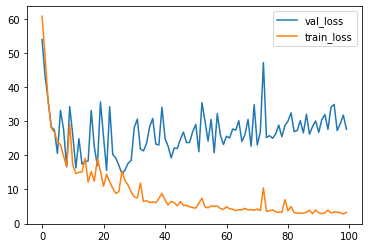

In [16]:
 pd.DataFrame(sgd_simple.history).plot()

### SGD with linear decay

In [17]:
sgd_linear = Trainer(neural_network_2, SGD(lr=0.05, final_lr = 0.001, decay_type='linear'))

sgd_linear.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 31.102
Validation loss after 20 epochs is 31.020
Validation loss after 30 epochs is 16.505
Validation loss after 40 epochs is 25.735
Validation loss after 50 epochs is 23.959
Validation loss after 60 epochs is 21.729
Validation loss after 70 epochs is 26.411
Validation loss after 80 epochs is 23.618
Validation loss after 90 epochs is 24.908
Validation loss after 100 epochs is 25.071


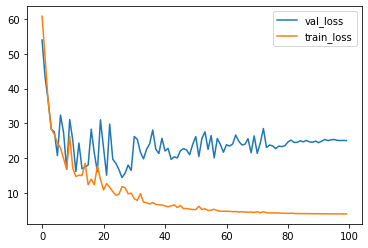

In [18]:
 pd.DataFrame(sgd_linear.history).plot()

### SGD with exponential decay

In [19]:
sgd_expon = Trainer(neural_network_2, SGD(lr=0.05, final_lr = 0.001, decay_type='exponential'))

sgd_expon.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 24.963
Validation loss after 20 epochs is 22.645
Validation loss after 30 epochs is 16.578
Validation loss after 40 epochs is 20.714
Validation loss after 50 epochs is 20.006
Validation loss after 60 epochs is 20.529
Validation loss after 70 epochs is 21.203
Validation loss after 80 epochs is 20.651
Validation loss after 90 epochs is 21.133
Validation loss after 100 epochs is 21.164


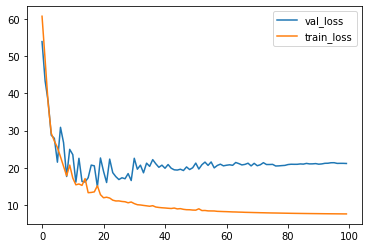

In [20]:
 pd.DataFrame(sgd_expon.history).plot()

### Simple SGDMomentum

In [21]:
sgdmomentum_simple = Trainer(neural_network_2, SGDMomentum(lr=0.05, momentum=0.9))

sgdmomentum_simple.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 36.872
Validation loss after 20 epochs is 41.454
Validation loss after 30 epochs is 35.179
Validation loss after 40 epochs is 36.663
Validation loss after 50 epochs is 36.742
Validation loss after 60 epochs is 45.657
Validation loss after 70 epochs is 40.555
Validation loss after 80 epochs is 36.968
Validation loss after 90 epochs is 40.915
Validation loss after 100 epochs is 36.788


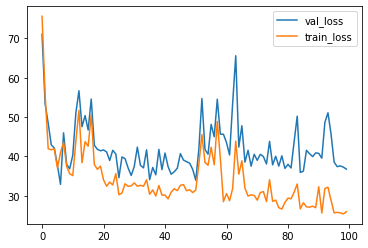

In [22]:
 pd.DataFrame(sgdmomentum_simple.history).plot()

### SGDMomentum with linear decay

In [23]:
sgdmomentum_linear = Trainer(neural_network_2, SGDMomentum(lr=0.05, final_lr = 0.001, decay_type='linear'))

sgdmomentum_linear.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 51.017
Validation loss after 20 epochs is 42.402
Validation loss after 30 epochs is 36.922
Validation loss after 40 epochs is 38.315
Validation loss after 50 epochs is 41.552
Validation loss after 60 epochs is 38.712
Validation loss after 70 epochs is 34.342
Validation loss after 80 epochs is 33.508
Validation loss after 90 epochs is 31.331
Validation loss after 100 epochs is 32.036


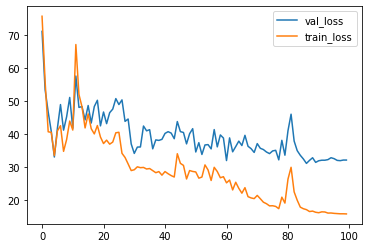

In [24]:
 pd.DataFrame(sgdmomentum_linear.history).plot()

### SGDMomentum with exponential decay

In [25]:
sgdmomentum_expon = Trainer(neural_network_2, SGDMomentum(lr=0.05, final_lr = 0.001, decay_type='exponential'))

sgdmomentum_expon.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 34.972
Validation loss after 20 epochs is 33.364
Validation loss after 30 epochs is 28.205
Validation loss after 40 epochs is 29.884
Validation loss after 50 epochs is 29.666
Validation loss after 60 epochs is 27.985
Validation loss after 70 epochs is 27.312
Validation loss after 80 epochs is 27.091
Validation loss after 90 epochs is 26.771
Validation loss after 100 epochs is 26.627


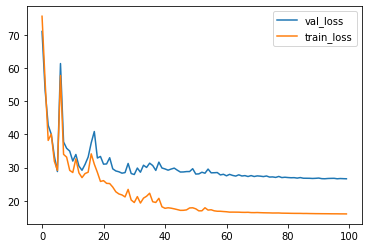

In [26]:
 pd.DataFrame(sgdmomentum_expon.history).plot()

### Simple SGD Nesterov

In [27]:
sgdnesterov_simple = Trainer(neural_network_2, SGDNesterov(lr=0.05, momentum=0.9))

sgdnesterov_simple.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 40.135
Validation loss after 20 epochs is 46.900
Validation loss after 30 epochs is 47.548
Validation loss after 40 epochs is 55.335
Validation loss after 50 epochs is 37.744
Validation loss after 60 epochs is 50.378
Validation loss after 70 epochs is 43.440
Validation loss after 80 epochs is 42.608
Validation loss after 90 epochs is 47.419
Validation loss after 100 epochs is 43.735


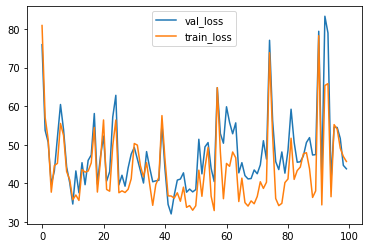

In [28]:
 pd.DataFrame(sgdnesterov_simple.history).plot()

### SGDNesterov with linear decay

In [29]:
sgdnesterov_linear = Trainer(neural_network_2, SGDNesterov(lr=0.05, final_lr = 0.001, decay_type='linear'))

sgdnesterov_linear.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 37.922
Validation loss after 20 epochs is 48.627
Validation loss after 30 epochs is 38.648
Validation loss after 40 epochs is 37.700
Validation loss after 50 epochs is 39.737
Validation loss after 60 epochs is 39.316
Validation loss after 70 epochs is 39.407
Validation loss after 80 epochs is 39.463
Validation loss after 90 epochs is 39.088
Validation loss after 100 epochs is 38.944


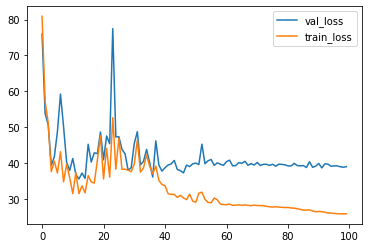

In [30]:
 pd.DataFrame(sgdnesterov_linear.history).plot()

### SGDNesterov with exponential decay

In [31]:
sgdnesterov_expon = Trainer(neural_network_2, SGDNesterov(lr=0.05, final_lr = 0.001, decay_type='exponential'))

sgdnesterov_expon.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 41.002
Validation loss after 20 epochs is 40.874
Validation loss after 30 epochs is 33.407
Validation loss after 40 epochs is 28.925
Validation loss after 50 epochs is 27.361
Validation loss after 60 epochs is 26.111
Validation loss after 70 epochs is 25.836
Validation loss after 80 epochs is 25.858
Validation loss after 90 epochs is 25.741
Validation loss after 100 epochs is 25.747


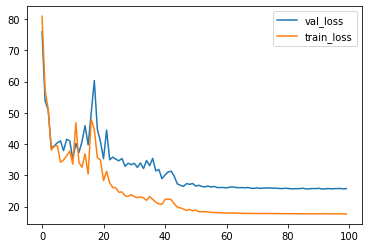

In [32]:
 pd.DataFrame(sgdnesterov_expon.history).plot()

### Adam

In [33]:
adam = Trainer(neural_network_2, Adam(lr=0.05, beta_1=0.9, beta_2=0.999))

adam.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 77.716
Validation loss after 20 epochs is 77.734
Validation loss after 30 epochs is 76.790
Validation loss after 40 epochs is 48.548
Validation loss after 50 epochs is 36.581
Validation loss after 60 epochs is 29.108
Validation loss after 70 epochs is 27.324
Validation loss after 80 epochs is 25.948
Validation loss after 90 epochs is 21.531
Validation loss after 100 epochs is 21.387


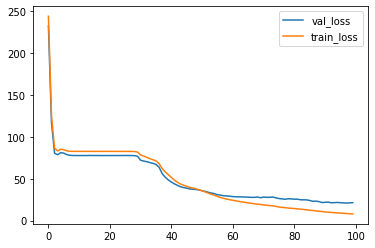

In [34]:
 pd.DataFrame(adam.history).plot()

### AdaGrad

In [35]:
adagrad = Trainer(neural_network_2, AdaGrad(lr=0.05))

adagrad.fit(X_train, y_train, X_val, y_val,
       epochs = 100,
       eval_every = 10,
       record_history = True,
       seed=1);

Validation loss after 10 epochs is 203.998
Validation loss after 20 epochs is 152.977
Validation loss after 30 epochs is 126.177
Validation loss after 40 epochs is 108.970
Validation loss after 50 epochs is 96.657
Validation loss after 60 epochs is 87.311
Validation loss after 70 epochs is 80.127
Validation loss after 80 epochs is 74.125
Validation loss after 90 epochs is 68.995
Validation loss after 100 epochs is 64.431


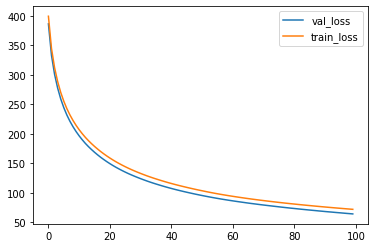

In [36]:
 pd.DataFrame(adagrad.history).plot()